# Estimating the SCC using CIL damage functions and the FAIR SCM

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2020
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

Note: This notebook allows users to generate the point estimate SCCs along with damage function uncertainty. 
Computing the climate uncertatinty required to compute the full uncertatinty SCCs requires the use of servers to run 100k simulations.
Code for this is provided in the `full_uncertainty_ensemble` notebook.

Note: Damage function units fed into this calculation should be billions of 2019 USD

#### Please activate the `mortalityverse` environment when running this notebook

## Set up workspace

In [1]:
! pip install fair==1.3.2

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair
import scale_ag02_scc

from scipy.stats import lognorm, norm

In [3]:
REPO = os.getenv('REPO')
DB = os.getenv('DB')
OUTPUT = os.getenv('OUTPUT')


# mortality specific parameratization for code below
version = 'v0.5' # code version
specification = 'mortality_quadratic_IGIA' # sector specific tag
ssp = 'SSP3'
MAGNITUDE_OF_DAMAGES = 1e9  # magnitude of damage function values


In [4]:
INPUT_data = '{}/4_damage_function/'.format(DB)
OUTPUT_data = '{}/5_scc/global_scc/quadratic'.format(DB)

In [6]:
# Code toggles

# point estimate (`point-est`) or df uncertainty (`df-uncertainty`) (note: df uncertainty will not generate some plots)
scc_output = 'point-est' 

# damages including or excluding adaptation costs (damages vs wo_costs)
costs = 'damages'

# generate plots or not
generate_plots = True

# Run option: whether or not to hold the post-2100 damage function constant.
hold_2100_damages_fixed = False # NOTE: False is the default setting used in the paper

In [7]:
if scc_output == 'point-est':
    index_cols = ['year', 'age_adjustment', 'vsl_value', 'heterogeneity']
    file_infix = ''
elif scc_output == 'df-uncertainty':
    index_cols = ['year', 'age_adjustment', 'vsl_value', 'heterogeneity', 'pctile']
    file_infix = 'quantilereg_'
    specification = '{}_{}'.format(specification, scc_output)
else:
    raise NotImplementedError

# Load FAIR Temperatures Anomaly

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions of methane and nitrous oxide are switched on.

# SCC

We can compute the SCC by adding an additional pulse in CO2 emissions to the RCP trajectory.

### Scenario design

This study uses a 100 Gt C emissions pulse. You can change the pulse amount by modifying the `PULSE_AMT` variable below, and adapting the `CONVERSION` value to match. 


In [8]:
PULSE_YEAR = 2020  # year in which pulse will be emitted. Update the PULSE_DEFLATOR accordingly
PULSE_AMT = 1.0  # in Gt C = 1e9 ton C

# CONVERSION is in units of [pulse/tCO2] = [1 pulse/PULSE_AMT GtC * 1 GtC/1e9 tC * 12tC/44tCO2]
# This is used to convert costs ($Bn_2019 / pulse) to SCC ($_2019/ton CO2).
# Therefore, it should be the inverse of any changes to PULSE_AMT
CONVERSION = 1.0 / PULSE_AMT / 1e9 * 12.011 / 44.0098

Finished loading FAIR


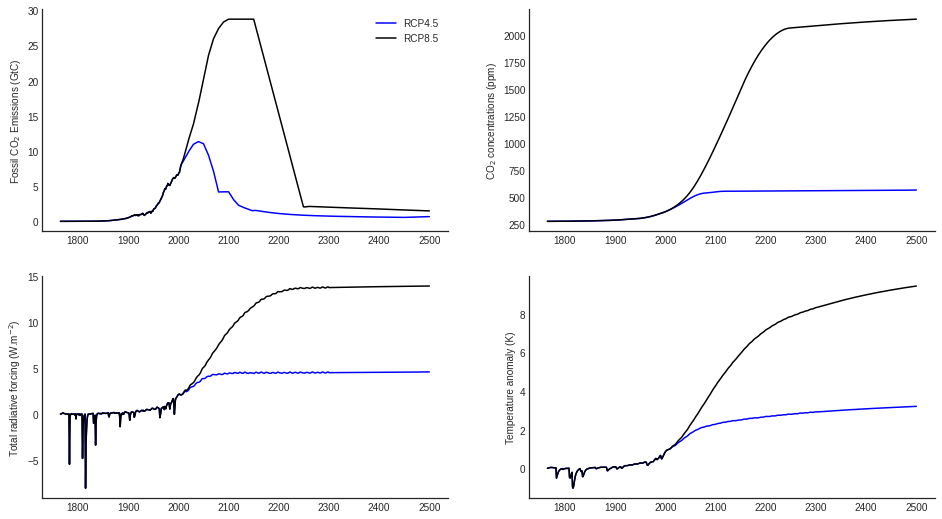

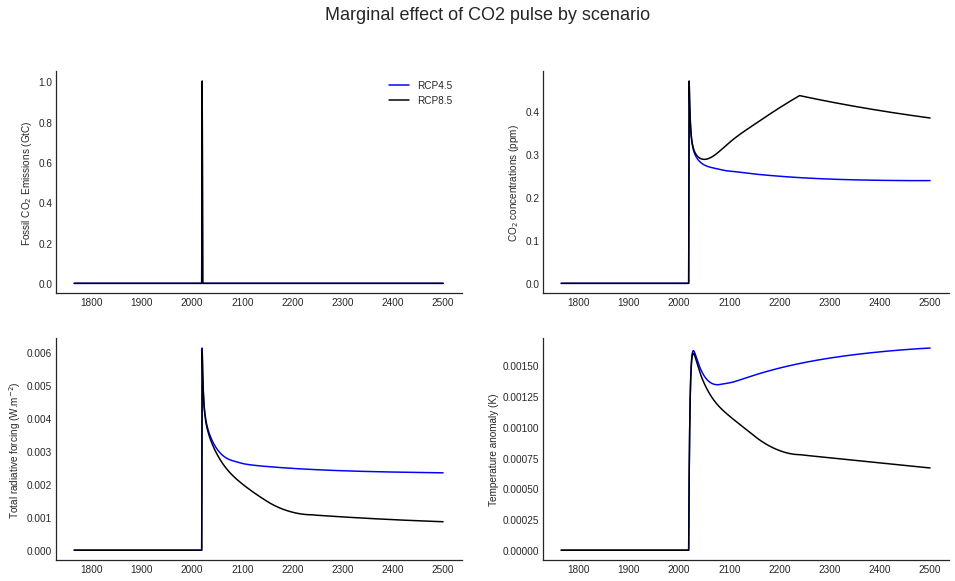

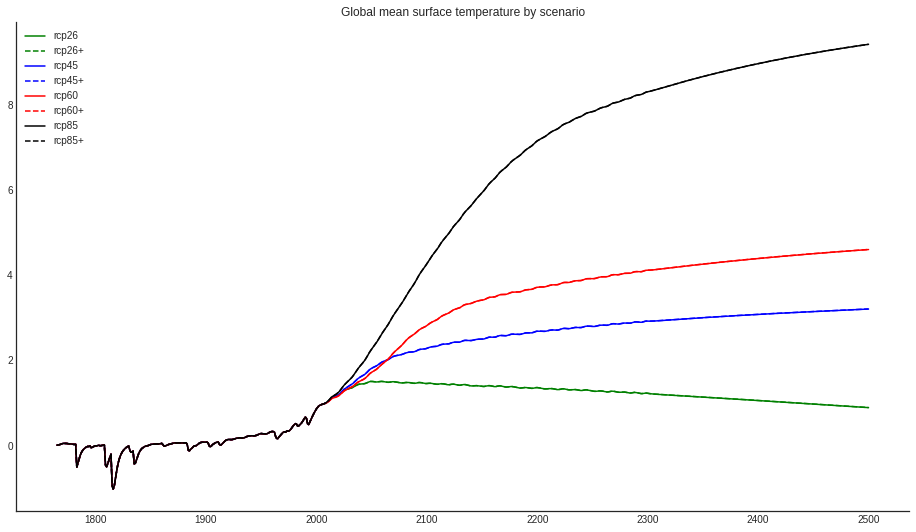

In [9]:
# make_plots = True generates Appendix chart G1 
fair_temperatures_anomaly = load_fair.temperatures_anomaly(PULSE_YEAR = PULSE_YEAR, 
                                                           PULSE_AMT = PULSE_AMT,
                                                           make_plots = True, 
                                                           output = OUTPUT_data)

## Incorporate a single damage function

This is the damage function generated in th `4_damage_function` step, with a set of coefficients for each year.

Note: The damage function can be held constant or allowed to vary post-2100. 

Note: the damage functions passed have columns for `anomalymin` and `anomalymax` which are not used, so they are dropped after reading in the .csv files below. In dropping them, the parameters fit to the damage function are given by `coeff_names` as defined here.

In [10]:
# Time the SCC calculation
startTime = datetime.now()

# damage function coeffs filepath 
if costs == 'damages':
    fp = os.path.join('{}{}/mortality_damage_coefficients_quadratic_IGIA_MC_global_poly4_uclip_sharecombo_{}{}.csv'
                      .format(INPUT_data, costs, file_infix, ssp))
elif costs == 'wo_costs':
    fp = os.path.join('{}{}/mortality_wo_costs_coefficients_quadratic_IGIA_MC_global_poly4_uclip_sharecombo_{}{}.csv'
                      .format(INPUT_data, costs, file_infix, ssp))    

def read_damage_func(fp, index):
    df = pd.read_csv(fp, index_col=index)
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ds = read_damage_func(fp, list(range(len(index_cols)))).to_dataset(name='SSP3')

# Drop 'anomalymin' and 'anomalymax' from the coeff list. Only keep the constants and the betas.
ds = ds.sel(coeff=[c for c in ds.coeff.values if 'anomaly' not in c])

In [11]:
# The following operation reorders the 'variable' and 'year' coordinates.
coeffs_all_years = (
    ds.to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)

if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)
    

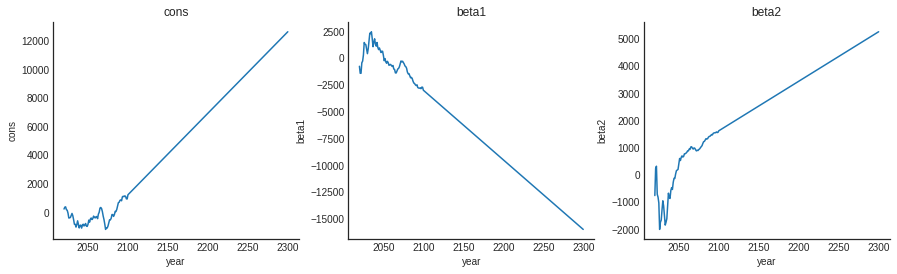

In [12]:
if generate_plots and scc_output == 'point-est':
    fig, axes = plt.subplots(1, len(ds.coeff.values), figsize=(15, 4))

    for i, coeff in enumerate(ds.coeff.values):
        lines = coeffs_all_years.sel(variable=ssp,age_adjustment='vsl', vsl_value='epa', heterogeneity='scaled')[coeff].plot.line(
            x='year', ax=axes[i], add_legend=False)
        
        axes[i].set_title(coeff)

    sns.despine()

<ipython-input-13-73fe97d63bf6>:53: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  axes[0, -1].legend(


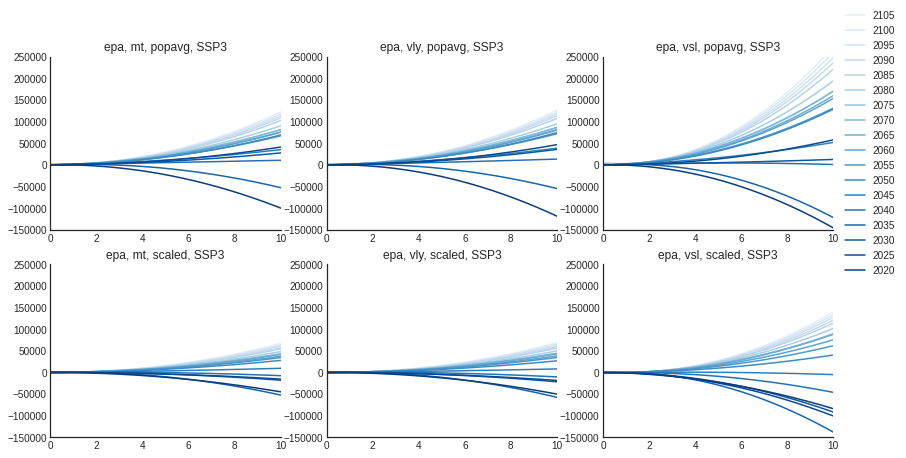

In [13]:
# Figure G4 - Temporal evolution of the global damage function
# Output: /figures/Figure_E4_damage_functions/damage_functions_IGIA_{specification}_{SSP}_2100-fixed-{TRUE/FALSE}.pdf

powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots and scc_output == 'point-est':
    
    output_dir = '{}/figures/Figure_E4_damage_functions'.format(OUTPUT)
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.age_adjustment)*len(coeffs_all_years.vsl_value)*len(coeffs_all_years.heterogeneity)
    fig, axes = plt.subplots(min(2, numvars), (numvars+1)//2, figsize=(15, 7))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    if 1 == 1:
        current_row = 0
        for hi, h in enumerate(coeffs_all_years.heterogeneity.values):
            current_col = -1
            if hi == 1:
                current_row = 1
            for ai, a in enumerate(coeffs_all_years.age_adjustment.values):
                for vi, v in enumerate(coeffs_all_years.vsl_value.values):
                    current_col += 1
                    lines = []
                    for y in reversed(coeffs_all_years.year.values[:86:5]):
                        #print(current_row, current_col)
                        lines.append(
                            axes[current_row, current_col].plot(
                                temps.values,
                                spaghetti.sel(vsl_value=v, age_adjustment=a, heterogeneity=h, year=y, variable=ssp).values,
                                color=matplotlib.cm.Blues_r((y-2015.0)/(2100-2000)),
                                label=int(y)))

                    axes[current_row, current_col].set_facecolor('white')
                    axes[current_row, current_col].set_title('{}, {}, {}, {}'.format(v, a, h, ssp))
                    axes[current_row, current_col].set_xbound(lower=0, upper=10)
                    axes[current_row, current_col].set_ybound(lower=-150000, upper=250000)

        plt.subplots_adjust(right=0.85)
        axes[0, -1].legend(
            list(reversed(lines))[::5],
            labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
            loc='center left',
            bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
        fig.set_facecolor('white')

        sns.despine()
        fig.savefig(os.path.join(output_dir, 'damage_functions_IGIA_{}_{}_{}_2100-fixed-{}.pdf'
                    .format(specification, ssp, version, hold_2100_damages_fixed)))


In [13]:
if generate_plots and scc_output == 'point-est':
    temps = np.linspace(-5, 15, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.age_adjustment)*len(coeffs_all_years.vsl_value)*len(coeffs_all_years.heterogeneity)
    fig, axes = plt.subplots(min(2, numvars), (numvars+1)//2, figsize=(15, 7))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    if 1 == 1:
        current_row = 0
        for hi, h in enumerate(coeffs_all_years.heterogeneity.values):
            current_col = -1
            if hi == 1:
                current_row = 1
            for ai, a in enumerate(coeffs_all_years.age_adjustment.values):
                for vi, v in enumerate(coeffs_all_years.vsl_value.values):
                    current_col += 1
                    lines = []
                    for y in reversed(coeffs_all_years.year.values[85::10]):
                        #print(current_row, current_col)
                        lines.append(
                            axes[current_row, current_col].plot(
                                temps.values,
                                spaghetti.sel(vsl_value=v, age_adjustment=a, heterogeneity=h, year=y, variable=ssp).values,
                                color=matplotlib.cm.Reds_r((y-2100.0)/(2300-2100)),
                                label=int(y)))

                    axes[current_row, current_col].set_facecolor('white')
                    axes[current_row, current_col].set_title('{}, {}, {}, {}'.format(v, a, h, ssp))
                    axes[current_row, current_col].set_xbound(lower=0, upper=10)
                    axes[current_row, current_col].set_ybound(lower=-200000, upper=300000)

        plt.subplots_adjust(right=0.85)
        axes[0, -1].legend(
            list(reversed(lines))[::5],
            labels=list(reversed(coeffs_all_years.year.values[85:]))[::10],
            loc='center left',
            bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
        fig.set_facecolor('white')

        sns.despine()

### Compute damages

Combine the damage function coefficients with the FAIR temperatures:

$$d_y = c_2*T_y^2+C_1*T_y+C_0 \hspace{1in}\forall \hspace{0.1in} y \in [2020, 2300]$$

In [14]:
damages = (
    (coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)).sum(dim='coeff'))

# Fix the coordinate re-order bug introduced by holding the damage function constant post-2100.
if scc_output == 'point-est':
    damages = damages.transpose('variable', 'year', 'pulse', 'rcp', 'age_adjustment', 'vsl_value', 'heterogeneity')
elif scc_output == 'df-uncertainty':
    damages = damages.transpose('variable', 'year', 'pulse', 'rcp', 'age_adjustment', 'vsl_value', 'heterogeneity', 'pctile')
else:
    raise NotImplementedError

### Plot time series of damages

In [15]:
if generate_plots and scc_output == 'point-est':
    fig, ax = plt.subplots(1, 1)

    colors = ['green', 'blue', 'red', 'black']
    styles = ['solid', 'dashed']

    lines = []
    labels = []
    for r, rcp in enumerate(damages.rcp.values):
        for p, pulse in enumerate(damages.pulse.values):
            labels.append('{}{}'.format(rcp, ['', '+'][p]))
            lines.append(
                ax.plot(
                    damages.year,
                    damages.sel(rcp=rcp, pulse=pulse, vsl_value='epa', age_adjustment='vly', heterogeneity='popavg', variable=ssp).T,
                    color=colors[r],
                    linestyle=styles[p])[0])

    plt.legend(lines, labels)
    ax.axes.set_title(
        'Time series of damages by scenario (Billion USD), Popavg VLY, EPA VSL',
        size=14)

    sns.despine()

### Plot time series of mortality damages by RCP and VSL measure (Billion USD)
Note that this is in Billion USD_2019, and is the damages from the 1GtC pulse. Previously, damages had been converted to a \$/tCO2 basis (or Billion \$/GtCO2). 

In [16]:
if generate_plots and scc_output == 'point-est':

    plotted = (
        (damages.sel(variable=ssp, rcp=['rcp45', 'rcp85']))
        .diff(dim='pulse').sel(pulse='pulse'))

    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    for r, rcp in enumerate(plotted.rcp):
        labels = []
        lines = []
        ii = 0
        for a, adj in enumerate(plotted.age_adjustment.values):
            for v, vsl in enumerate(plotted.vsl_value.values):
                for h, heterogeneity in enumerate(plotted.heterogeneity.values):
                    labels.append((adj, vsl, heterogeneity))
                    lines.append(
                        axes[r%2].plot(
                            plotted.year.values,
                            (
                                plotted
                                .sel(
                                    rcp=rcp,
                                    age_adjustment=adj,
                                    vsl_value=vsl,
                                    heterogeneity=heterogeneity)),
                            color=['lightblue', 'blue', 'lightgreen', 'green','lightcoral','red'][ii],
                            linestyle=('dashed' if h == 0 else 'solid'),
                            label='{}, {}, {}'.format(adj, vsl, heterogeneity))[0])
                    ii += 1

        axes[r%2].set_title('Damages by VSL measure, {}'.format(rcp.data))
        axes[r%2].set_facecolor('white')

    axes[1].legend(
        lines,
        ['{} {} {}'.format(*tuple(s)) for s in labels],
        bbox_to_anchor=(1.1, 1),
        loc='center left')

    fig.suptitle('Mortality damages for SSP3 by RCP and VSL measure (Billion USD_2019 from 1GtC pulse)', size=18)
    fig.set_facecolor('white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    sns.despine()

### Compue the SCC (NPV of damages)

discount the time series of damages using the formula

$$SCC=\sum_{y\in\left[2020, 2300\right]}{\frac{d_y}{\left({1+r}\right)^{y-2020}}}$$

Compute the time series of discounted damages. Then plot time series of mortality damages by RCP and VSL measure (Billion USD), discounted to present value and per ton CO2. 

Note that the plots are in Billion USD_2019, discounted to 2020, for RCP 8.5, with EPA VSL, value of life years, and globally varying income ('scaled') under SSP3. We want plots evaluated for discount rates 2.5%, 3%, and 5%.

In [17]:
discrates = [1., 1.5, 2., 2.5, 3., 5., 7.]

discdata = []
for r in discrates:
    discdata.append(damages / (1+r/100)**(damages.year - 2020))

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))


In [18]:
# Useful for diagnostics.

plotted_npv = (
    (current_equivalent_damages.sel(
        variable=ssp, rcp=['rcp45'], age_adjustment='vly', vsl_value='epa', heterogeneity='scaled', discrate=3.0))
    .diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
plotted_npv = plotted_npv.to_dataframe("dr3")

plotted_damages = (
    (damages.sel(
        variable=ssp, rcp=['rcp45'], age_adjustment='vly', vsl_value='epa', heterogeneity='scaled'))
    .diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
plotted_damages = plotted_damages.to_dataframe("dr0")

plotted_df = plotted_npv.merge(plotted_damages, on=['year','rcp'])[['dr3','dr0']]

In [19]:
if generate_plots and scc_output == 'point-est':
    discrates_to_plot = [2.5, 3., 5.]
    
    a='vly'
    v='epa'
    h='scaled'
    
    plotted = (
        (current_equivalent_damages.sel(
            variable=ssp, rcp=['rcp45', 'rcp85'], age_adjustment=a, vsl_value=v, heterogeneity=h))
        .diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    for r, rcp in enumerate(plotted.rcp):
        labels = []
        lines = []
        for dr in discrates_to_plot:
            labels.append((dr))

            lines.append(
                axes[r%2].plot(
                    plotted.year.values,
                    (
                        plotted
                        .sel(
                            rcp=rcp,
                            discrate=dr)),
                    #color=['lightblue', 'blue', 'lightgreen', 'green'][discrates_to_plot.index(dr)],
                    color=matplotlib.cm.Blues_r(float(discrates_to_plot.index(dr))/len(discrates_to_plot)),
                    linestyle=('solid'),
                    label='{}'.format(dr))[0])

        axes[r%2].set_title('Present value of damages ($/ton CO2), {}'.format(rcp.data))
        axes[r%2].set_facecolor('white')

    axes[1].legend(
        lines,
        ['{}'.format(s) for s in labels],
        bbox_to_anchor=(1.1, 1),
        loc='center left')

    fig.suptitle('Present value of mortality damages for {} by RCP and discount rate - {}-{}-{}'.format(ssp, a, v, h), size=18)
    fig.set_facecolor('white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    sns.despine()

### Compute the SCC (sum of discounted marginal damage time series) by discount rate and RCP

In [20]:
scc = (
    (current_equivalent_damages.diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_pre_2100 = (
    (current_equivalent_damages.sel(year=slice(2020, 2099)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_post_2100 = (
    (current_equivalent_damages.sel(year=slice(2100, 3000)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))


scc = xr.concat([scc, scc_pre_2100, scc_post_2100], pd.Index(['all', 'pre2100', 'post2100'], name='time_cut'))


In [23]:
# you may use this to filter/view specific SCCs - only use if point estimate results
# df-quantiles still needs smoothing step below
scc.sel(time_cut='all').sel(rcp='rcp85').sel(discrate=3).sel(heterogeneity='scaled')

<xarray.DataArray (variable: 1, age_adjustment: 3, vsl_value: 1)>
array([[[14.32892487],
        [14.18665438],
        [22.14345164]]])
Coordinates:
  * variable        (variable) object 'SSP3'
  * age_adjustment  (age_adjustment) object 'mt' 'vly' 'vsl'
  * vsl_value       (vsl_value) object 'epa'
    heterogeneity   <U6 'scaled'
    pulse           <U5 'pulse'
    rcp             <U5 'rcp85'
    discrate        float64 3.0
    time_cut        <U3 'all'

### Export point estimate SCC to CSV

In [24]:
if scc_output == 'point-est':

    (   scc
        .to_series()
        .unstack('rcp')
        .to_csv('{}/scc_{}_{}_pulse{}GtC_{}_median_IGIA_2100-fixed-{}_MC.csv'.format(OUTPUT_data, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed))  ) 

    print(datetime.now() - startTime)

0:02:24.413981


In [26]:
# save a file with appended Ashenfelter_Greenstone 2002 conversion
if scc_output == 'point-est':
    scale_ag02_scc.Ashenfelter_Greenstone(OUTPUT_data,
        'scc_{}_{}_pulse{}GtC_{}_median_IGIA_2100-fixed-{}_MC.csv'.format(specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed))

Appended AG SCC
Saved: scc_mortality_quadratic_IGIA_SSP3_pulse1.0GtC_v0.5_median_IGIA_2100-fixed-False_MC_ag02.csv


if you are running `point-est`, the workflow ends here

## Damage function uncertainty 

### Plot histogram of quantiles of the SCC, upweighting each quantile by its associated mass in the economic uncertainty distribution.

New quantiles are [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95], probability weights are each 0.05 except for the 5th and 95th quantiles, which are weighted 0.075 to account for the fact that they cover more of the range than all other quantiles (0 to .075 and .925 to 1, respectively). Note that these weights are calculated with the function get_weights, rather than being hard-coded as before.

In [27]:
def get_weights(quantiles):
    """
        Compute the weights of each quantile regression.
        `quantiles` must be between 0-1! 
    """
    quantiles = np.array(quantiles)
    # find midpoints between quantiles
    bounds = np.array([0] + ((quantiles[:-1] + quantiles[1:]) / 2).tolist() + [1])
    if (bounds > 1).any():
        raise RuntimeError('quantiles must be between 0-1')
    weights = np.diff(bounds)
    return weights

In [28]:
if scc_output == 'df-uncertainty':
    weights = get_weights(scc.pctile)

In [29]:
if scc_output == 'df-uncertainty':
    fig, axes = plt.subplots(6, 2, figsize=(40, 25))
    #fig, axes = plt.subplots(4, 3, figsize=(8, 5))

    # it = lambda x: tqdm.tqdm_notebook(list(enumerate(x.values)), leave=False)
    it = lambda x: list(enumerate(x.values))

    plotting = scc.sel(rcp=['rcp45', 'rcp85'], discrate=3.0)

    weights = np.array(weights)
    hist_bins = range(-100, 310, 10)
    ii = 0

    for ri, rcp in it(plotting.rcp):
        for ai, age in it(plotting.age_adjustment):
            for vi, vsl in it(plotting.vsl_value):
                for hi, het in it(plotting.heterogeneity):
                    #for di, disc in it(plotting.discrate):

                    print(ii, rcp, age, vsl, het)
                    slicers = dict(
                        #discrate=disc,
                        rcp=rcp,
                        age_adjustment=age,
                        vsl_value=vsl,
                        heterogeneity=het,
                        time_cut='all')

                    this = plotting.sel(**slicers)

                    ax = axes[ri*3+ai, vi*2+hi]
                    #print(this.values)
                    #print('di is: {}'.format(di))

                    #mask = (this.values > 0)
                    ax.hist(
                        this.values[0,:],
                        #np.log(this.values[mask]),
                        bins=hist_bins,
                        density=True,
                        color=['red', 'green', 'blue','orange','yellow','purple'][2],
                        alpha=0.45,
                        weights=weights)

                    #ax.set_xticklabels(['$10^{{{:0.0f}}}$'.format(i) for i in ax.get_xticks()])
                    ax.set_title('{} {} {} {} 3%disc'.format(rcp,age,vsl,het))
                    ii += 1

    fig.suptitle('SCC - Economic Uncertainty', size=40)

In [30]:
if scc_output == 'df-uncertainty':
    # Save the IQRs resulting from the 25,75 ptiles of the damage function
    dmg_IQRs = scc.sel(pctile=[0.25,0.75],time_cut='all')

    # Save IQRs from fitting a distribution of type fit_type
    my_IQRs = scc.sel(pctile=[0.25,0.75],time_cut='all')

    fit_type = 'norm' #'lognorm' or 'norm' - 'norm' is standard

    for ri, rcp in it(scc.rcp):
        for ai, age in it(scc.age_adjustment):
            for vi, vsl in it(scc.vsl_value):
                for hi, het in it(scc.heterogeneity):
                    for di, disc in it(scc.discrate):

                        slicers = dict(
                            discrate=disc,
                            rcp=rcp,
                            age_adjustment=age,
                            vsl_value=vsl,
                            heterogeneity=het,
                            time_cut='all')

                        this = scc.sel(**slicers)

                        if fit_type == 'lognorm':
                            # Fit a lognormal distribution
                            # Helpful: https://stackoverflow.com/questions/51410155/proper-way-to-fit-a-lognormal-distribution-with-weight-in-python
                            logs = np.log(this.values[0,:])
                            muhat = np.average(logs, weights=weights)
                            # varhat is the weighted variance of ln(x).  There isn't a function in
                            # numpy for the weighted variance, so we compute it using np.average.
                            varhat = np.average((logs - muhat)**2, weights=weights)

                            shape = np.sqrt(varhat)
                            scale = np.exp(muhat)
                            #print('{} {}'.format(shape, scale))

                            if ~np.isnan(shape):
                                randoms = lognorm.rvs(s=shape, scale=scale, size=1000)
                                pt = np.percentile(randoms,[25, 75])
                            else:
                                pt = np.array([np.nan, np.nan])
                        else:
                            # Fit a normal distribution
                            muhat = np.average(this.values[0,:], weights=weights)
                            varhat = np.average((this.values[0,:] - muhat)**2, weights=weights)
                            scale = np.sqrt(varhat)
                            randoms = norm.rvs(loc=muhat, scale=scale, size=1000)
                            pt = np.percentile(randoms,[25, 75])


                        iqr_slicers = dict(
                            discrate=disc,
                            rcp=rcp,
                            age_adjustment=age,
                            vsl_value=vsl,
                            heterogeneity=het)

                        my_IQRs.loc[iqr_slicers] = pt

                        # Add the SCCs associated with the 25 and 75 quantile damage functions
                        tmp = scc.sel(**slicers)
                        dmg_IQRs.loc[iqr_slicers] = tmp.sel(pctile=[0.25,0.75])   

In [27]:
# you may use this to filter/view specific SCCs - only use if df-uncertainty results
my_IQRs.sel(heterogeneity='scaled').sel(discrate=[1.5, 2, 3, 5]).sel(rcp='rcp85').sel(age_adjustment='mt')

<xarray.DataArray (discrate: 4, variable: 1, vsl_value: 1, pctile: 2)>
array([[[[ -2.2690497 , 115.03153189]]],


       [[[-10.37222094,  70.27449836]]],


       [[[ -9.91178224,  33.03655914]]],


       [[[ -5.38197171,  14.31832161]]]])
Coordinates:
  * variable        (variable) object 'SSP3'
    age_adjustment  <U2 'mt'
  * vsl_value       (vsl_value) object 'epa'
    heterogeneity   <U6 'scaled'
  * pctile          (pctile) float64 0.25 0.75
    pulse           <U5 'pulse'
    rcp             <U5 'rcp85'
  * discrate        (discrate) float64 1.5 2.0 3.0 5.0
    time_cut        <U3 'all'

In [43]:
if scc_output == 'df-uncertainty':
    (
        my_IQRs
        .to_series()
        .unstack('rcp')
        .to_csv('{}/uncertainty/scc_IQRs_{}_{}_{}_pulse{}GtC_{}_2100-fixed-{}_v2.csv'.format(OUTPUT_data, fit_type, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed)))

    (
        dmg_IQRs
        .to_series()
        .unstack('rcp')
        .to_csv('{}/uncertainty/scc_IQRs_dmg-mapping_{}_{}_pulse{}GtC_{}_2100-fixed-{}.csv'.format(OUTPUT_data, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed)))


In [31]:
# save a file with appended Ashenfelter_Greenstone 2002 conversion
if scc_output == 'df-uncertainty':
    scale_ag02_scc.Ashenfelter_Greenstone('{}/uncertainty/'.format(OUTPUT_data),
        'scc_IQRs_{}_{}_{}_pulse{}GtC_{}_2100-fixed-{}_v2.csv'.format(fit_type, specification, ssp, PULSE_AMT, version, hold_2100_damages_fixed))